<a href="https://colab.research.google.com/github/TryOn-A-Virtual-Fitting-Service/clothes-image-classification-analysis/blob/main/cloth_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 환경 설정

In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display


In [ ]:
RANDOM_STATE = 33

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 데이터 불러오기(드라이브 마운트)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_ = Path('/content/drive/MyDrive/imagedata')
file_paths = list(dir_.glob(r'**/*.jpg'))

In [ ]:
### 이미지 경로를 데이터 프레임 형태로 만드는 함수
def process_img(file_path):
  """
    이미지 데이터의 경로와 label 데이터로 데이터 프레임 제작
  """

  labels = [str(file_path).split("/")[-2] for file_path in file_paths]

  file_path = pd.Series(file_path, name='Filepath').astype(str)
  labels = pd.Series(labels, name='Label')

  # 경로와 라벨 붙이기
  df = pd.concat([file_path, labels], axis=1)

  # index 재설정
  df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

  return df

In [ ]:
df = process_img(file_paths)
df.head()

,Filepath,Label
0,/content/drive/MyDrive/imagedata/LongPants/Lon...,LongPants
1,/content/drive/MyDrive/imagedata/Sleeveless/Sl...,Sleeveless
2,/content/drive/MyDrive/imagedata/Outerwear/Out...,Outerwear
3,/content/drive/MyDrive/imagedata/Accessories/A...,Accessories
4,/content/drive/MyDrive/imagedata/Sleeveless/Sl...,Sleeveless


In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 4500

Number of different labels: 8

Labels: ['LongPants' 'Sleeveless' 'Outerwear' 'Accessories' 'ShortPants'
 'ShortSleeve' 'Shoes' 'LongSleeve']


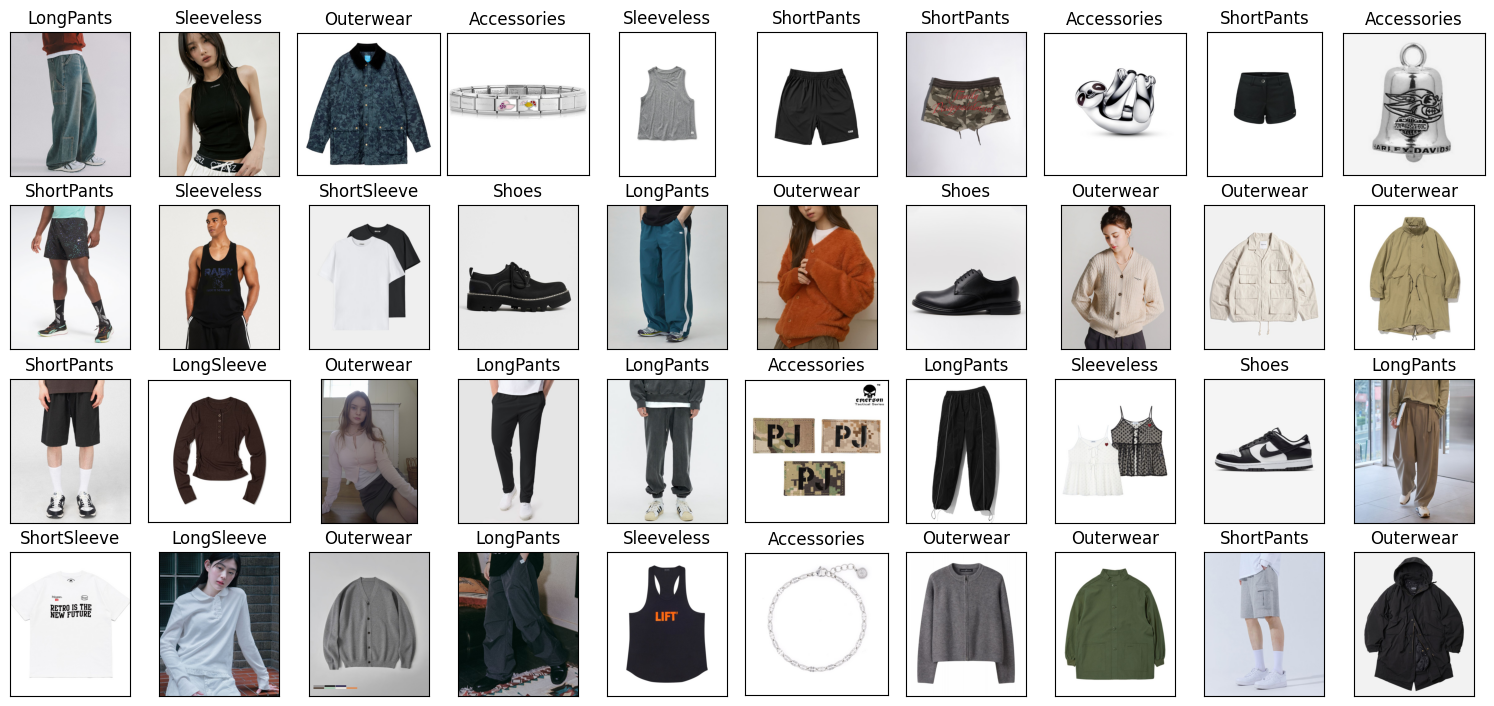

In [ ]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()


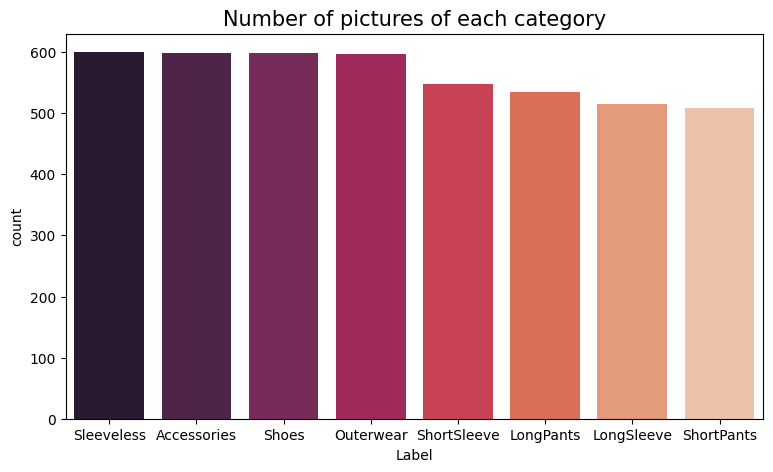

In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x=vc.index, y=vc, palette="rocket", hue=vc.index, legend=False)
plt.title("Number of pictures of each category", fontsize=15)
plt.show()


In [ ]:
### Training+Validation/Test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) # 학습 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=RANDOM_STATE)
train_df.shape,test_df.shape

((4050, 2), (450, 2))

### 모델 전처리

In [ ]:
### Training/Validation split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/imagedata',
                                                 target_size=(150, 150),  # (200, 200)의 경우 overfiting이 너무 심했음
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 subset='training')

val_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/imagedata',
                                                target_size=(150, 150),
                                                batch_size=32,
                                                class_mode='categorical',
                                                subset='validation')




Found 3604 images belonging to 8 classes.
Found 896 images belonging to 8 classes.


### CNN 베이스라인 모델 생성 및 성능 측정

In [ ]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=8, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])
cnn.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,319,720 (20.29 MB)

 Trainable params: 5,319,720 (20.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 720s 6s/step - accuracy: 0.3366 - loss: 1.8879 - val_accuracy: 0.5625 - val_loss: 1.3190
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 223ms/step - accuracy: 0.6794 - loss: 0.9601 - val_accuracy: 0.6027 - val_loss: 1.1690
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 228ms/step - accuracy: 0.8403 - loss: 0.5104 - val_accuracy: 0.6417 - val_loss: 1.2005
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 226ms/step - accuracy: 0.9303 - loss: 0.2410 - val_accuracy: 0.6562 - val_loss: 1.4504
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 226ms/step - accuracy: 0.9720 - loss: 0.1021 - val_accuracy: 0.6775 - val_loss: 1.6990
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 231ms/step - accuracy: 0.9897 - loss: 0.0504 - val_accuracy: 0.6272 - val_loss: 1.9674
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 235ms/step - accuracy: 0.9821 - loss: 0.0637 - val_accuracy: 0.6451 - val_loss: 2.0549
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 233ms/step - accuracy: 0.9805 - loss: 0.0803 - val_a

### 데이터 증강

In [ ]:
### 생성기 및 증강된 데이터 로드하는 함수


def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=RANDOM_STATE,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    # Test 데이터는 증강X
    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator, test_generator, train_images, val_images, test_images


### 전이학습

In [ ]:
### 전이학습 모델 딕셔너리

models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}


In [ ]:
# generator 만들기
train_generator, test_generator, train_images, val_images, test_images = create_gen()

Found 3645 validated image filenames belonging to 8 classes.
Found 405 validated image filenames belonging to 8 classes.
Found 450 validated image filenames belonging to 8 classes.


In [ ]:
def get_model(model):
    kwargs =    {
        'input_shape':(224, 224, 3),
        'include_top':False,
        'weights':'imagenet',
        'pooling':'avg'
                }

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(8, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
### 전이 학습 수행
for name, model in models.items():

    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)

    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


DenseNet121          trained in 86.92 sec
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2          trained in 48.22 sec
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
DenseNet201          trained in 111.38 sec
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
EfficientNetB0       trained in 68.54 sec
27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
EfficientNetB1       trained in 81.9 sec
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
InceptionV3          trained in 61.77 sec
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV3Large     trained in 52.49 sec
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
ResNet152V2          trained in 80.67 sec
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
ResNet50             trained in 49.74 sec
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50V2           trained in 41.77 sec
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG19                trained in 67.3 sec
58889256/58889256 ━━━━━━━━━━━

In [ ]:
# test 데이터로 모델 성능 예측 및 추론 시간 측정
for name, model in models.items():

    # 추론 시간 측정 시작
    start_time = perf_counter()

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)

    # 추론 시간 측정 종료
    total_inference_time = perf_counter() - start_time
    models[name]['inference_time'] = round(total_inference_time, 4)  # 전체 추론 시간 저장

    # 배치당 이미지 수 계산 및 하나의 이미지당 추론 시간 계산
    total_images = test_images.samples
    per_image_time = total_inference_time / total_images
    models[name]['per_image_time'] = round(per_image_time, 6)  # 하나의 이미지 추론 시간 저장

    # 예측 값 처리
    pred = np.argmax(pred, axis=1)

    # 라벨 맵핑
    labels = (train_images.class_indices)
    labels = dict((v, k) for k, v in labels.items())
    pred = [labels[k] for k in pred]

    # 실제 y_test와 비교하여 정확도 계산
    y_test = list(test_df.Label)
    acc = accuracy_score(y_test, pred)
    models[name]['acc'] = round(acc, 4)  # 정확도 저장

    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set, total inference time: {total_inference_time:.4f} sec, '
          f'and {per_image_time:.6f} sec per image**')

# Create a DataFrame with the results (추론 시간 및 하나의 이미지 시간 추가)
models_result = []

for name, v in models.items():
    models_result.append([name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf'],
                          models[name]['inference_time'],  # 전체 추론 시간
                          models[name]['per_image_time']])  # 하나의 이미지당 추론 시간

df_results = pd.DataFrame(models_result,
                          columns=['model', 'val_accuracy', 'accuracy', 'Training time (sec)', 'Inference time (sec)', 'Per image time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True, drop=True)
df_results


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step
**DenseNet121 has a 88.22% accuracy on the test set, total inference time: 3.3616 sec, and 0.007470 sec per image**
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step
**MobileNetV2 has a 89.56% accuracy on the test set, total inference time: 3.3096 sec, and 0.007355 sec per image**
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step
**DenseNet201 has a 90.67% accuracy on the test set, total inference time: 3.3523 sec, and 0.007450 sec per image**
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step
**EfficientNetB0 has a 14.22% accuracy on the test set, total inference time: 3.2731 sec, and 0.007274 sec per image**
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step
**EfficientNetB1 has a 10.44% accuracy on the test set, total inference time: 3.5722 sec, and 0.007938 sec per image**
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step
**InceptionV3 has a 85.33% accuracy on the test set, total inference time: 3.5391 sec, and 0.007865 sec per image**
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step
**MobileNet

,model,val_accuracy,accuracy,Training time (sec),Inference time (sec),Per image time (sec)
0,DenseNet201,0.8988,0.9067,111.38,3.3523,0.007450
1,Xception,0.8815,0.9000,62.02,3.5610,0.007913
2,MobileNetV2,0.9062,0.8956,48.22,3.3096,0.007355
3,ResNet50V2,0.8963,0.8933,41.77,3.3293,0.007399
4,DenseNet121,0.8741,0.8822,86.92,3.3616,0.007470
5,ResNet152V2,0.8815,0.8711,80.67,3.4148,0.007588
6,InceptionV3,0.8790,0.8533,61.77,3.5391,0.007865
7,VGG19,0.7481,0.7378,67.30,3.2598,0.007244
8,VGG16,0.7407,0.7200,31.18,3.3445,0.007432
9,MobileNetV3Large,0.5556,0.5600,52.49,3.3065,0.007348


### 데이터 분석

<ipython-input-25-6c26b19c32ff>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(df_results['model']))  # 색상 팔레트 사용


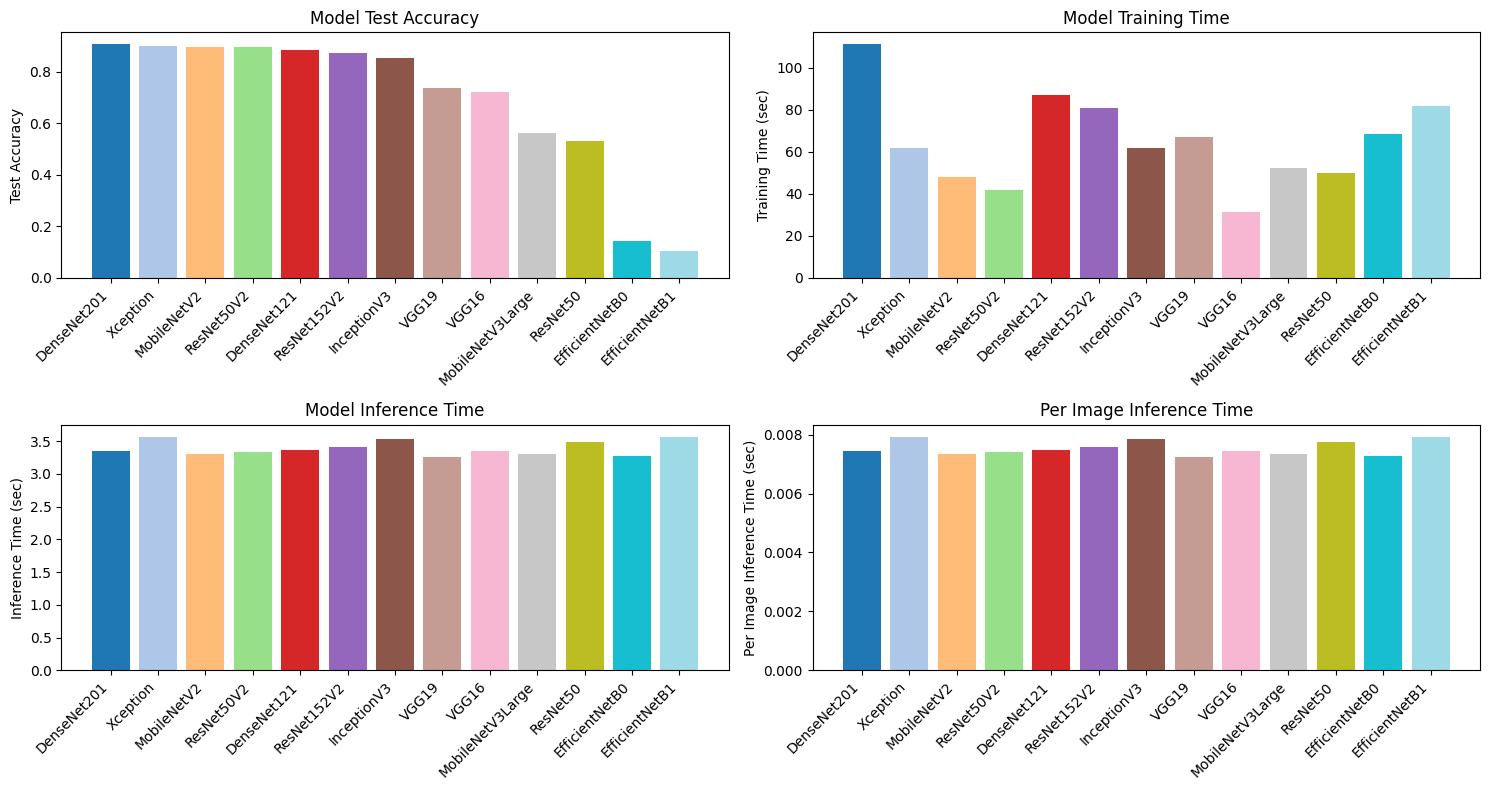

In [ ]:
# 모델별로 색깔을 다르게 지정하여 시각화
colors = plt.cm.get_cmap('tab20', len(df_results['model']))  # 색상 팔레트 사용

plt.figure(figsize=(15, 8))

# 서브플롯 1: 모델별 테스트 정확도 비교 (막대 그래프)
plt.subplot(2, 2, 1)
plt.bar(df_results['model'], df_results['accuracy'], color=[colors(i) for i in range(len(df_results['model']))])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Test Accuracy')
plt.title('Model Test Accuracy')

# 서브플롯 2: 모델별 학습 시간 비교 (막대 그래프)
plt.subplot(2, 2, 2)
plt.bar(df_results['model'], df_results['Training time (sec)'], color=[colors(i) for i in range(len(df_results['model']))])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Training Time (sec)')
plt.title('Model Training Time')

# 서브플롯 3: 모델별 전체 추론 시간 비교 (막대 그래프)
plt.subplot(2, 2, 3)
plt.bar(df_results['model'], df_results['Inference time (sec)'], color=[colors(i) for i in range(len(df_results['model']))])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Inference Time (sec)')
plt.title('Model Inference Time')

# 서브플롯 4: 모델별 하나의 이미지당 추론 시간 비교 (막대 그래프)
plt.subplot(2, 2, 4)
plt.bar(df_results['model'], df_results['Per image time (sec)'], color=[colors(i) for i in range(len(df_results['model']))])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Per Image Inference Time (sec)')
plt.title('Per Image Inference Time')

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()


### MobileNetV2 선택 및 검증

In [26]:
# train/test 데이터 분리
train_df, test_df = train_test_split(df, test_size=0.1, random_state=RANDOM_STATE)

# 생성기 생성
train_generator, test_generator, train_images, val_images, test_images = create_gen()

# MobileNetV2 모델로 전이 학습 모델 생성
model = get_model(tf.keras.applications.MobileNetV2)

# 모델 학습
history = model.fit(train_images, validation_data=val_images, epochs=7)


Found 3645 validated image filenames belonging to 8 classes.
Found 405 validated image filenames belonging to 8 classes.
Found 450 validated image filenames belonging to 8 classes.
Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 40s 277ms/step - accuracy: 0.7330 - loss: 0.8450 - val_accuracy: 0.9037 - val_loss: 0.2885
Epoch 2/7
114/114 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.9234 - loss: 0.2337 - val_accuracy: 0.9210 - val_loss: 0.2422
Epoch 3/7
114/114 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - accuracy: 0.9497 - loss: 0.1490 - val_accuracy: 0.9111 - val_loss: 0.2603
Epoch 4/7
114/114 ━━━━━━━━━━━━━━━━━━━━ 29s 239ms/step - accuracy: 0.9595 - loss: 0.1051 - val_accuracy: 0.9136 - val_loss: 0.2679
Epoch 5/7
114/114 ━━━━━━━━━━━━━━━━━━━━ 28s 231ms/step - accuracy: 0.9759 - loss: 0.0790 - val_accuracy: 0.9136 - val_loss: 0.2734
Epoch 6/7
114/114 ━━━━━━━━━━━━━━━━━━━━ 29s 237ms/step - accuracy: 0.9822 - loss: 0.0492 - val_accuracy: 0.9062 - val_loss: 0.3072
Epoch 7/7
114/114 ━━━━━━━━━━━━━━━━━━━━ 28s 232ms/step - accuracy: 0.9851 - loss: 0.0418 - val_accuracy: 0.9160 - val_loss: 0.2901


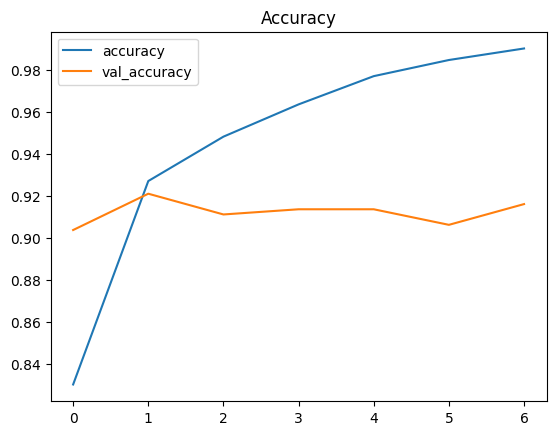

In [28]:
# accuracy 시각화
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

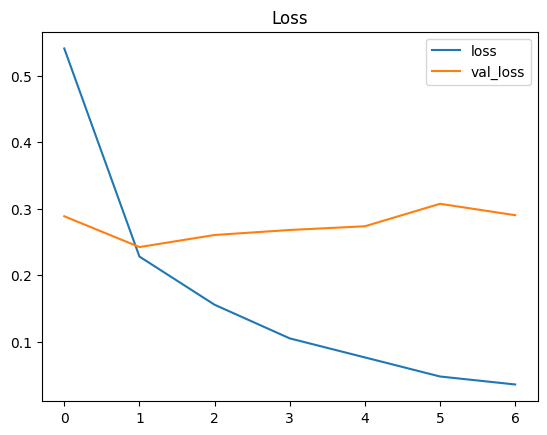

In [29]:
# loss 시각화
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

In [30]:
# MobileNetV2 모델로 학습 완료 후 테스트 데이터에서 성능 평가
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# 레이블 맵핑
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# 실제 y_test 레이블과 비교하여 정확도 계산
y_test = list(test_df.Label)
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 387ms/step
Accuracy on the test set: 90.89%


In [32]:
# 정밀도 및 재현율 확인

class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

 Accessories       0.93      0.93      0.93        60
   LongPants       0.94      0.94      0.94        54
  LongSleeve       0.77      0.84      0.80        56
   Outerwear       0.95      0.79      0.86        47
       Shoes       0.98      0.97      0.98        64
  ShortPants       0.92      0.94      0.93        47
 ShortSleeve       0.90      0.90      0.90        60
  Sleeveless       0.89      0.94      0.91        62

    accuracy                           0.91       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.91      0.91      0.91       450



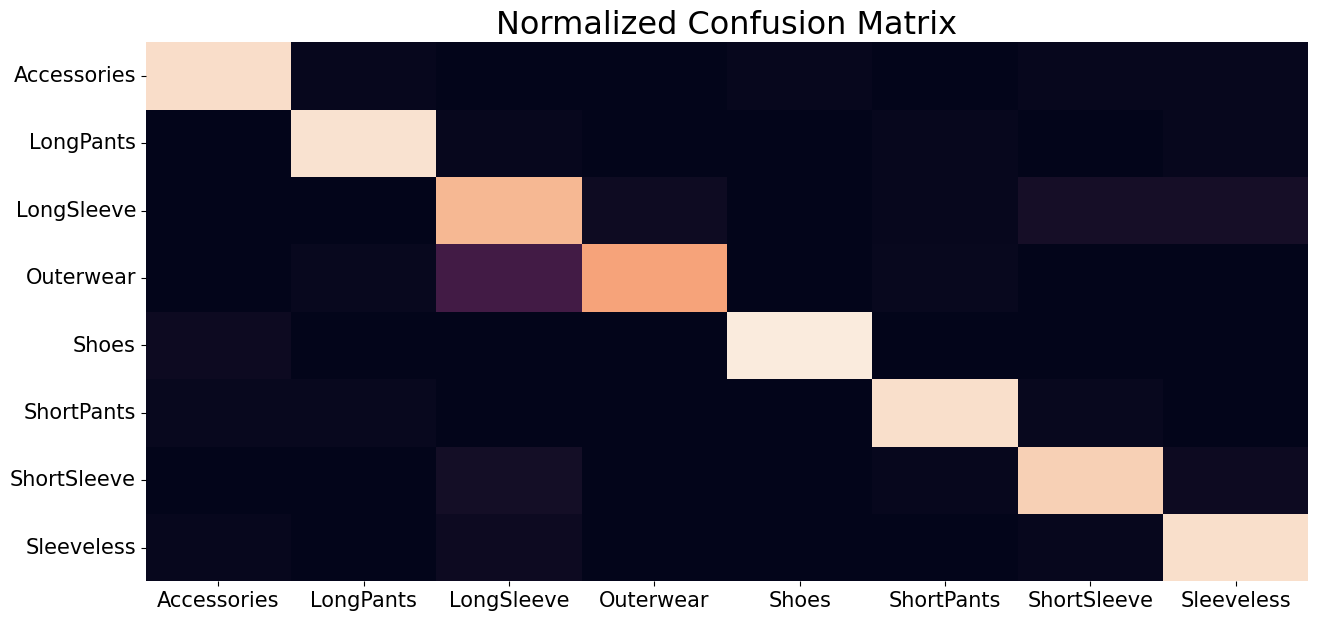

In [34]:
# confusion matrix 시각화

from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

번호를 입력하세요 : 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


## 예측률 : 98.47%

### Class prediction = Sleeveless

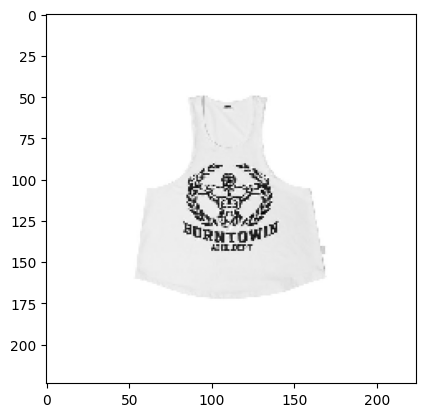

In [36]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from IPython.display import Markdown, display

# Markdown으로 출력하는 함수
def printmd(string):
    display(Markdown(string))

class_dictionary = {'Accessories': 0,
                    'LongPants': 1,
                    'LongSleeve': 2,
                    'Outerwear': 3,
                    'Shoes': 4,
                    'ShortPants': 5,
                    'ShortSleeve': 6,
                    'Sleeveless': 7}

# 이미지 크기 설정
IMAGE_SIZE = (224, 224)

# 사용자 입력으로 테스트할 이미지 선택
number_1 = int(input("번호를 입력하세요 : "))  # 예: 10, 50, 100
test_image_path = test_df.iloc[number_1, 0]  # 테스트할 이미지 경로

# 테스트 이미지 불러오기 및 전처리
test_image = image.load_img(test_image_path, target_size=IMAGE_SIZE)
test_image = image.img_to_array(test_image)
plt.imshow(test_image / 255.0)  # 이미지 시각화

# 이미지 전처리 및 reshape (MobileNetV2에 맞게 전처리)
test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)

# 예측 수행 (학습된 모델 사용)
prediction = model.predict(test_image)

# 예측 결과 정리 및 출력
df = pd.DataFrame({'pred': prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')

# 가장 높은 확률의 클래스 예측률 출력
printmd(f"## 예측률 : {(df.iloc[0]['pred']) * 100:.2f}%")

# 클래스 이름 출력
for class_name, class_index in class_dictionary.items():
    if class_index == df.index[0]:
        printmd(f"### Class prediction = {class_name}")
        break


In [38]:
# 전체 모델 저장
model.save('mobilenet_v2_fashion_classifier.h5')

# 가중치만 저장
model.save_weights('mobilenet_v2_fashion_classifier.weights.h5')

In [39]:
# 로컬로 파일 다운로드
from google.colab import files

files.download('mobilenet_v2_fashion_classifier.h5')  # 전체 모델
files.download('mobilenet_v2_fashion_classifier.weights.h5')  # 가중치만


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>